# are we in an AI bubble?

over the last few years, AI-related companies (especially chip designers and big tech) have delivered huge stock-market gains. This has led to constant claims that “we’re in an AI bubble” – but also counter-claims that these moves are justified by fundamentals.

in this project i try to **quantify** that debate using market data from Yahoo Finance.  
the goal is not to *prove* or *disprove* a bubble (which is basically impossible in real time), but to ask:

> do AI-related stocks behave in a way that is **consistent with bubble-like hype** compared to the rest of the market?

i focus on:

- an **equal-weight basket of AI-related stocks and ETFs**
- broad **benchmarks**: Nasdaq-100 (QQQ), S&P 500 (SPY), and a semiconductor ETF (SOXX)
- **risk and return metrics**: cumulative performance, volatility, rolling Sharpe ratios, drawdowns
- **dependencies** between AI names: return correlations

everything is implemented in a small Python package (`bubble/`) with functions for loading data, computing indicators and plotting results.

In [66]:
# fix for relative imports when running as a script
import sys
from pathlib import Path

project_root = Path("..").resolve()
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

In [67]:
# import modules from the bubble package
from bubble.loader import load_stock_data
from bubble.indicators import (
    calculate_returns,
    calculate_index_returns,
    build_equal_weight_index,
    calculate_rolling_volatility,
    calculate_rolling_correlation,
    calculate_rolling_sharpe,
    calculate_drawdown,
    calculate_max_drawdown,
)
from bubble.visualizations import (
    plot_correlation_matrix,
    plot_rolling_correlation,
    plot_rolling_volatility,
    plot_rolling_sharpe,
    plot_index_vs_benchmark,
    plot_drawdown,
    plot_return_distribution,
    plot_normalized_prices
)

## 1. data and universe

to keep the analysis transparent, i use **only publicly available daily data** from Yahoo Finance via the `yfinance` API.

- **AI-related names** (stocks + ETFs):

  `NVDA, MSFT, GOOGL, META, AMZN, TSM, AMD, AVGO, ASML, BOTZ, ARKQ, AIQ`

  this mix of stocks consists of:
  - AI hardware (NVDA, AMD, AVGO, ASML, TSM)
  - big tech platforms embedding AI (MSFT, GOOGL, META, AMZN)
  - AI/robotics themed ETFs (BOTZ, ARKQ, AIQ)

- **benchmarks**

  - `QQQ` – Nasdaq-100 (growth / big tech)
  - `SPY` – S&P 500 (broad US market)
  - `SOXX` – semiconductor ETF (sector benchmark)

i start in **January 2020**, just before the COVID crash and long before the ChatGPT / generative-AI hype, and download daily closing prices.

In [68]:
# define the list of stock tickers
tickers = [
    "NVDA", 
    "MSFT", 
    "GOOGL", 
    "META", 
    "AMZN",
    "TSM", 
    "AMD", 
    "AVGO", 
    "ASML", 
    "BOTZ", 
    "ARKQ", 
    "AIQ"
]

# define benchmark tickers
benchmark_tickers = {
    "QQQ": "Nasdaq 100 (QQQ)",
    "SPY": "S&P 500 (SPY)",
    "SOXX": "Semiconductors (SOXX)",
}

In [69]:
# load stock data for AI-related companies
ai_stock_data = load_stock_data(tickers)
ai_stock_data.tail(3)

Ticker,AIQ,AMD,AMZN,ARKQ,ASML,AVGO,BOTZ,GOOGL,META,MSFT,NVDA,TSM
Date,,,,,,,,,,,,
2025-11-25,49.250000,206.130005,229.669998,107.470001,1003.219971,385.029999,34.549999,323.440002,636.219971,476.98999,177.820007,284.679993
2025-11-26,49.669998,214.240005,229.160004,109.160004,1040.969971,397.570007,34.869999,319.950012,633.609985,485.50000,180.259995,289.959991
2025-11-28,50.139999,217.529999,233.220001,109.959999,1060.000000,402.959991,35.169998,320.179993,647.950012,492.01001,177.000000,291.510010


In [70]:
# print summary information about the loaded data
print("✅ AI stock data loaded")
print(f"tickers: {', '.join(map(str, ai_stock_data.columns))}")
print(
    f"data range: {ai_stock_data.index.min().date()} → "
    f"{ai_stock_data.index.max().date()}"
)
print(f"number of rows: {len(ai_stock_data)}")

✅ AI stock data loaded
tickers: AIQ, AMD, AMZN, ARKQ, ASML, AVGO, BOTZ, GOOGL, META, MSFT, NVDA, TSM
data range: 2020-01-02 → 2025-11-28
number of rows: 1486


In [71]:
# load stock data for benchmark indices
benchmark_stock_data = load_stock_data(list(benchmark_tickers.keys()))
benchmark_stock_data.tail(3)

Ticker,QQQ,SOXX,SPY
Date,,,
2025-11-25,608.890015,283.579987,675.020020
2025-11-26,614.270020,291.390015,679.679993
2025-11-28,619.250000,296.739990,683.390015


In [72]:
# print summary information about the loaded data
print("✅ Benchmark stock data loaded")
print(f"tickers: {', '.join(map(str, benchmark_stock_data.columns))}")
print(
    f"data range: {benchmark_stock_data.index.min().date()} → "
    f"{benchmark_stock_data.index.max().date()}"
)
print(f"number of rows: {len(benchmark_stock_data)}")

✅ Benchmark stock data loaded
tickers: QQQ, SOXX, SPY
data range: 2020-01-02 → 2025-11-28
number of rows: 1486


### check: price data for selected tickers and benchmarks

the tables above confirm that:

- all selected tickers have price data from early 2020 onwards.
- the date indices line up so we can safely compute multi-asset returns and indices.
- there are no obvious gaps or weird NaNs once we drop empty columns.

## 2. how have AI stocks performed?

a natural first question is simply: **how much have AI-exposed names gone up since 2020?**

to compare stocks with very different price levels, I normalize each series to **1.0 at the start date** and plot the full time paths on the same chart. This shows cumulative performance in relative terms (e.g. 4.0 means “4× the starting value”).

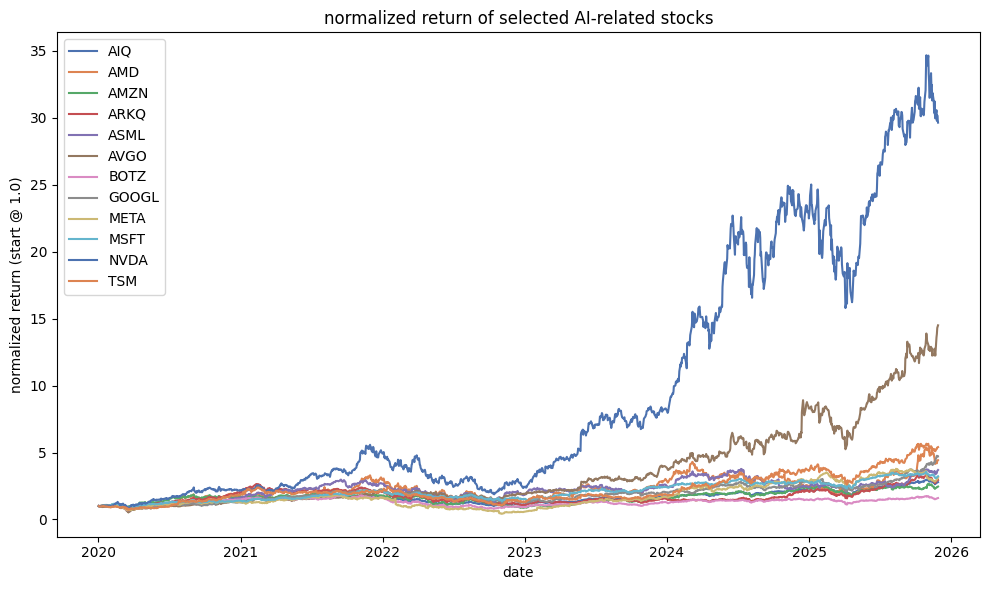

In [73]:
# plot normalized prices for AI stocks
plot_normalized_prices(ai_stock_data)

the normalized price chart shows:

- a **huge spread** in outcomes:
  - some AI names have gone roughly **2–4×** since 2020 – strong but not insane.
  - a few (notably **NVDA** and **AVGO**) have gone **10×**, with very steep moves from 2023 onwards.
- the path is very **boom-and-bust**, with a big drawdown in 2022 and a sharp recovery afterwards.

this already hints at **AI hype being highly concentrated** in a small number of “AI champions”, rather than evenly spread across all AI-related stocks.

## 3. AI basket vs major benchmarks

to compare AI as a *sector* to the overall market, i:

1. construct an **equal-weight AI index**:  
   each stock is normalised to 1.0 on the first day and i take the cross-sectional average.
2. normalize the **benchmarks** (`QQQ`, `SPY`, `SOXX`) the same way.
3. plot the index levels together to see how AI has done relative to:
   - growth / big tech in general (QQQ),
   - the broad US market (SPY),
   - the semiconductor sector (SOXX).

In [74]:
# build equal-weighted index for AI stocks
ai_index = build_equal_weight_index(ai_stock_data)
ai_index_returns = calculate_index_returns(ai_index, log_returns=True)

In [75]:
# initialize dictionaries for benchmark indices and returns
bench_indices = {}
bench_returns = {}

# normalize benchmark stock data
bench_normalized = benchmark_stock_data / benchmark_stock_data.iloc[0]

# calculate benchmark indices and returns
for ticker, label in benchmark_tickers.items():
    idx = bench_normalized[ticker]
    bench_indices[ticker] = idx
    bench_returns[ticker] = calculate_index_returns(idx, log_returns=True)

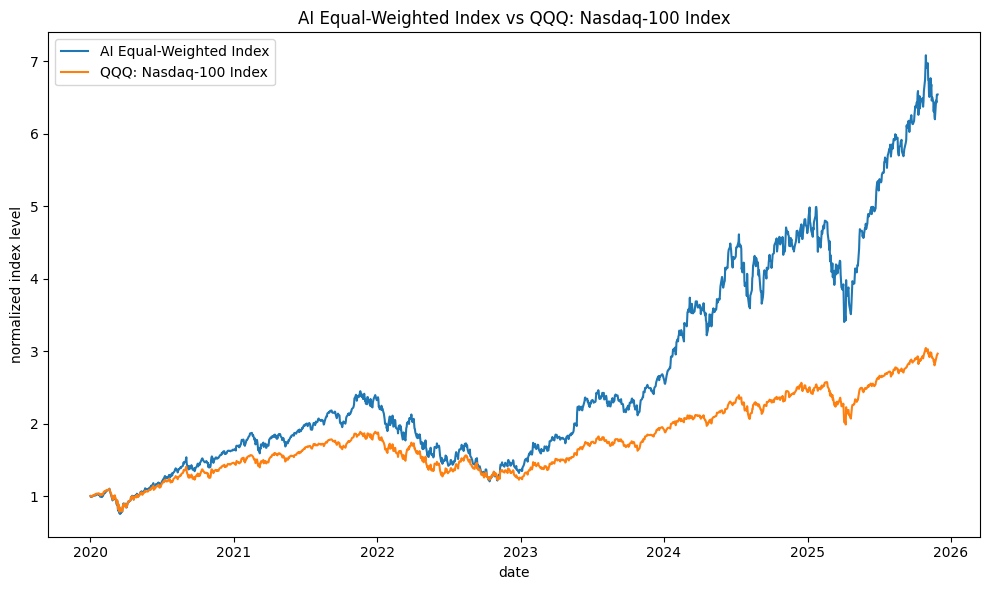

In [76]:
# plot AI equal-weighted index vs. QQQ benchmark
plot_index_vs_benchmark(
    ai_index, 
    bench_indices["QQQ"],
    ai_label="AI Equal-Weighted Index",
    benchmark_label="QQQ: Nasdaq-100 Index"
)

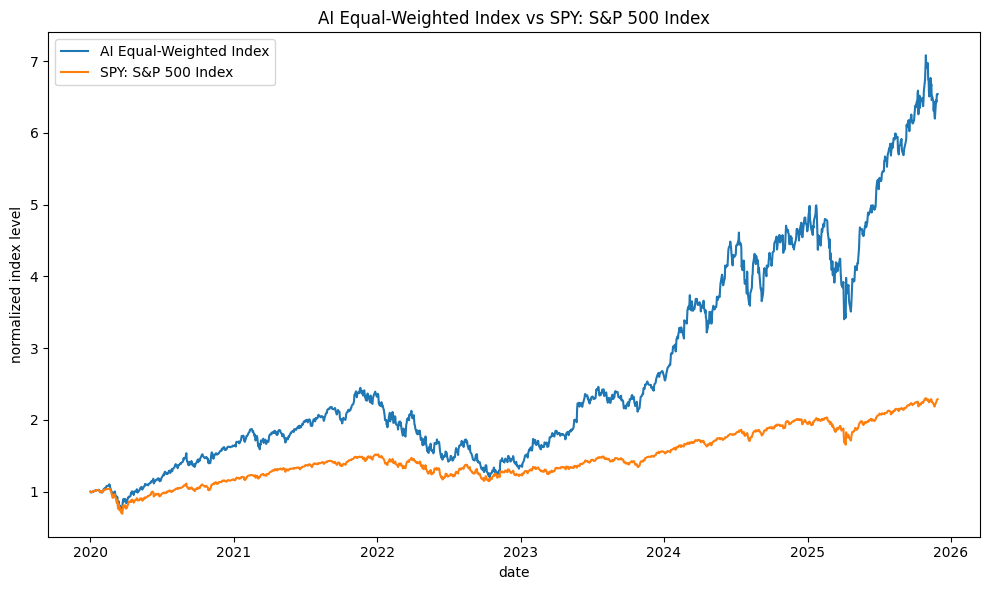

In [77]:
# plot AI equal-weighted index vs. SPY benchmark
plot_index_vs_benchmark(
    ai_index, 
    bench_indices["SPY"],
    ai_label="AI Equal-Weighted Index",
    benchmark_label="SPY: S&P 500 Index"
)

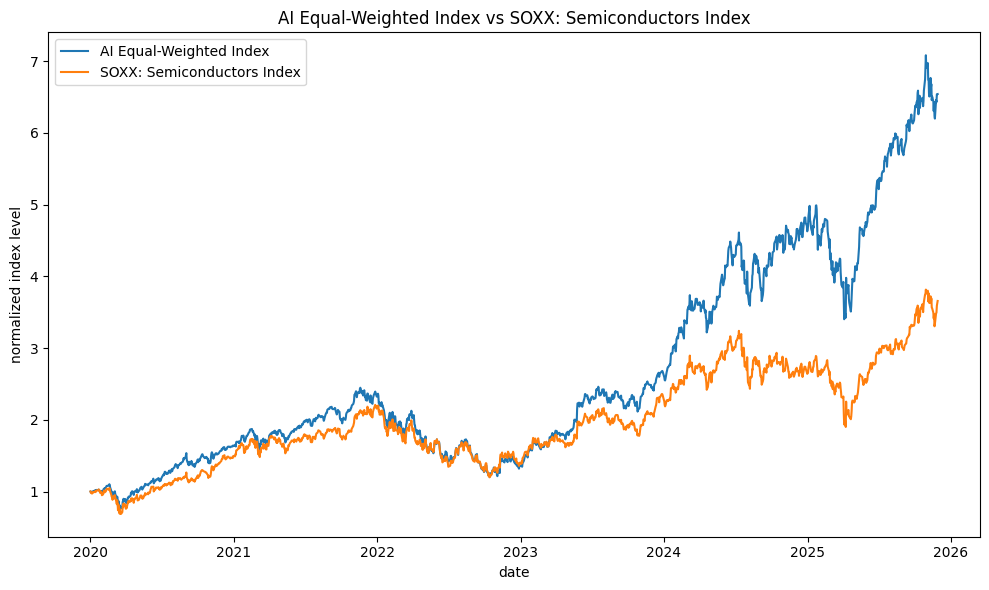

In [78]:
# plot AI equal-weighted index vs. SOXX benchmark
plot_index_vs_benchmark(
    ai_index, 
    bench_indices["SOXX"],
    ai_label="AI Equal-Weighted Index",
    benchmark_label="SOXX: Semiconductors Index"
)

the equal-weight AI basket has clearly **outpaced all three benchmarks**:

- by late 2025, the AI basket is roughly **6–7×** its 2020 level, versus about **3× for QQQ** and less for SPY.
- performance relative to **SOXX** shows that even within semiconductors, the AI names have been at the high end of the move.

this pattern is **consistent with strong AI hype**:
AI exposure has been rewarded much more than broad tech or the market, especially since 2023.  
however, outperformance alone doesn’t prove a bubble – we also need to look at **risk, correlations and drawdowns**.

## 4. correlations and crowding

another hallmark of “hot” themes is that stocks start moving **more tightly together** as they get traded as a single story. to explore this, i:

- compute **daily log returns** for each AI stock.
- plot the **static correlation matrix** of returns over the sample.
- compute and plot a **60-day rolling average correlation** to see how integration changes over time.

In [79]:
# calculate log returns for AI stocks
ai_log_returns = calculate_returns(ai_stock_data, log_returns=True)
ai_log_returns.tail(3)

Ticker,AIQ,AMD,AMZN,ARKQ,ASML,AVGO,BOTZ,GOOGL,META,MSFT,NVDA,TSM
Date,,,,,,,,,,,,
2025-11-25,0.002847,-0.042364,0.014870,0.013301,0.015470,0.018533,0.013990,0.015140,0.037098,0.006288,-0.026252,0.000140
2025-11-26,0.008492,0.038590,-0.002223,0.015603,0.036938,0.032050,0.009219,-0.010849,-0.004111,0.017684,0.013628,0.018377
2025-11-28,0.009418,0.015240,0.017562,0.007302,0.018116,0.013466,0.008567,0.000719,0.022380,0.013320,-0.018250,0.005331


In [80]:
# calculate rolling volatility correlation for the 60-day window
rolling_corr = calculate_rolling_correlation(ai_log_returns, window=60)
rolling_corr.tail(3)

Date
2025-11-25    0.505759
2025-11-26    0.512955
2025-11-28    0.512458
dtype: float64

In [81]:
# calculate rolling volatility for the 60-day window
rolling_vol = calculate_rolling_volatility(ai_log_returns, window=60)
rolling_vol.tail(3)

Ticker,AIQ,AMD,AMZN,ARKQ,ASML,AVGO,BOTZ,GOOGL,META,MSFT,NVDA,TSM
Date,,,,,,,,,,,,
2025-11-25,0.236803,0.740755,0.352646,0.342989,0.368396,0.508584,0.238548,0.338039,0.342434,0.183620,0.378044,0.361583
2025-11-26,0.237068,0.744048,0.352643,0.342943,0.373539,0.511408,0.239001,0.295641,0.342290,0.187526,0.378956,0.362334
2025-11-28,0.237553,0.744225,0.343732,0.343087,0.372848,0.511496,0.239507,0.295780,0.344095,0.189339,0.380816,0.361404


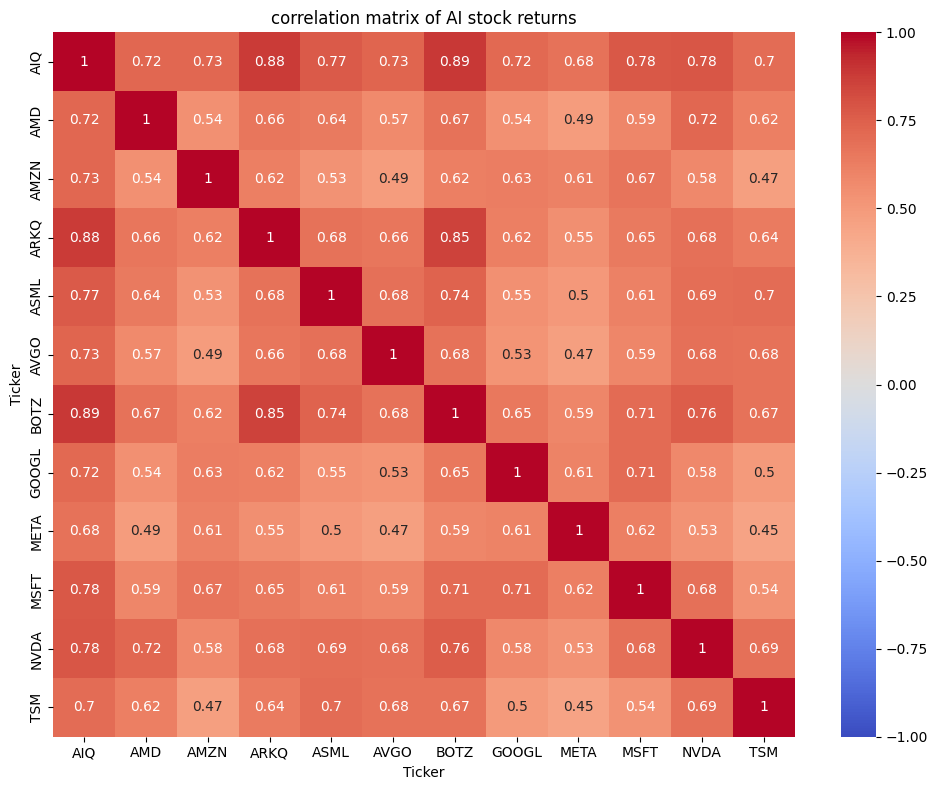

In [82]:
# plot correlation matrix for AI stock returns
plot_correlation_matrix(ai_log_returns)

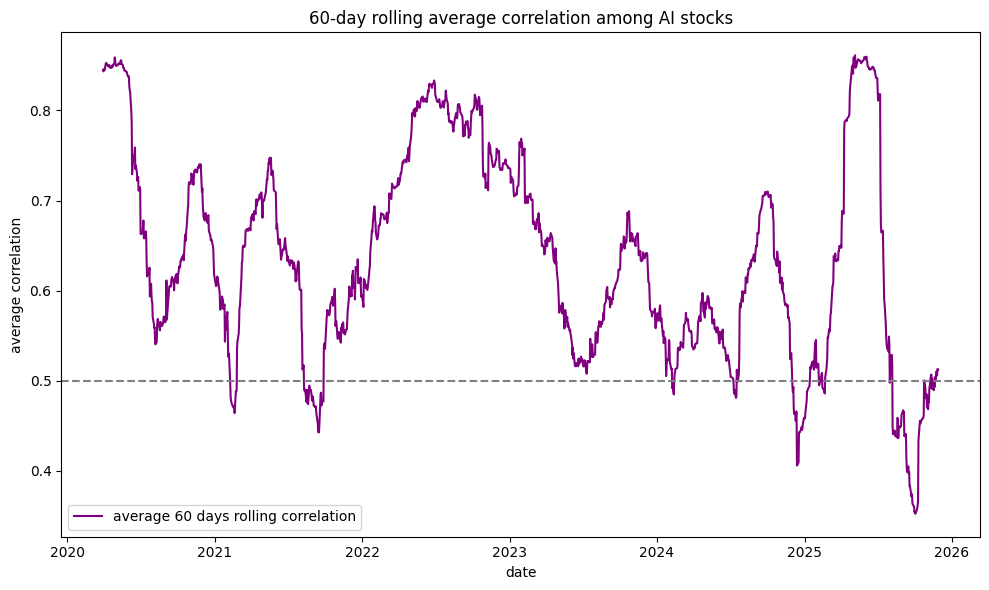

In [83]:
# plot rolling correlation for AI stock returns
plot_rolling_correlation(rolling_corr)

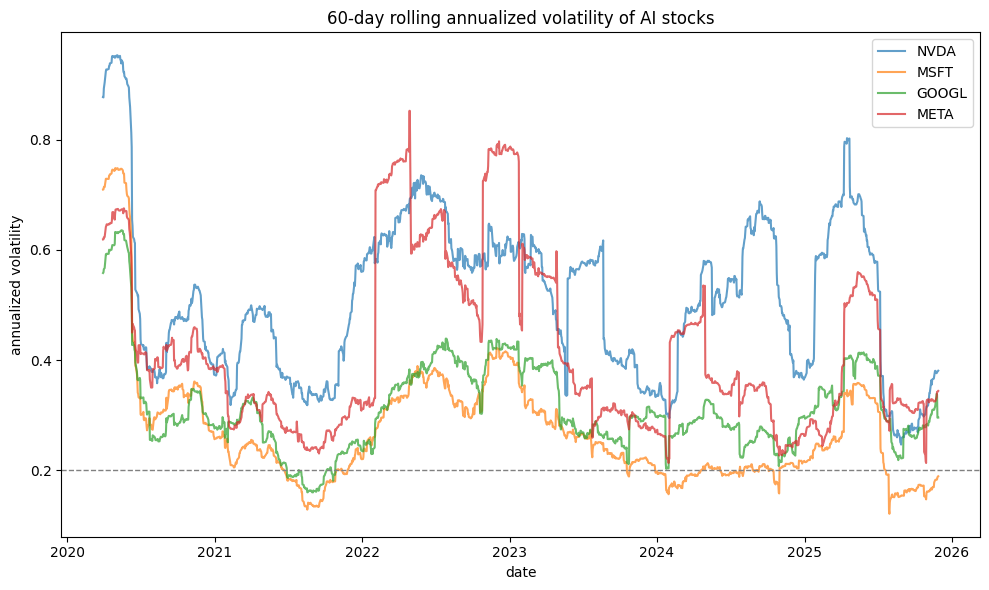

In [84]:
# plot rolling volatility for AI stock returns
plot_rolling_volatility(rolling_vol, subset=["NVDA", "MSFT", "GOOGL", "META"])

the correlation heatmap shows that AI names have been **moderately to strongly positively correlated** over the full period.

the 60-day rolling correlation chart adds more nuance:

- correlations spike during **stress and hype episodes** (e.g. the COVID crash, the 2022 tech selloff, and the 2023–2024 AI melt-up).
- in calmer periods correlations drop back somewhat, but overall remain elevated compared to a completely diversified portfolio.

the 60-day rolling volatility plot for selected names (NVDA, MSFT, GOOGL, META) also shows clear spikes around the COVID crash, the 2022 selloff and the 2023–2024 AI rally, reinforcing that these are high-beta, high-risk stocks.

this behaviour suggests that AI stocks are often traded as a **single “AI trade”**, which is exactly the kind of crowding one would expect in a thematic boom.

## 5. risk and reward: volatility, Sharpe ratios and drawdowns

to understand whether investors are being compensated for taking risk in AI stocks, i compute:

- a **60-day rolling Sharpe ratio** for the AI basket.
- **drawdowns** (percentage drop from the previous peak) to see how painful crashes have been.

In [85]:
# calculate rolling Sharpe ratio for the 60-day window
rolling_sharpe = calculate_rolling_sharpe(ai_index_returns, window=60)
rolling_sharpe.tail(3)

Date
2025-11-25    1.723728
2025-11-26    1.853993
2025-11-28    1.730629
Name: equal_weight_index, dtype: float64

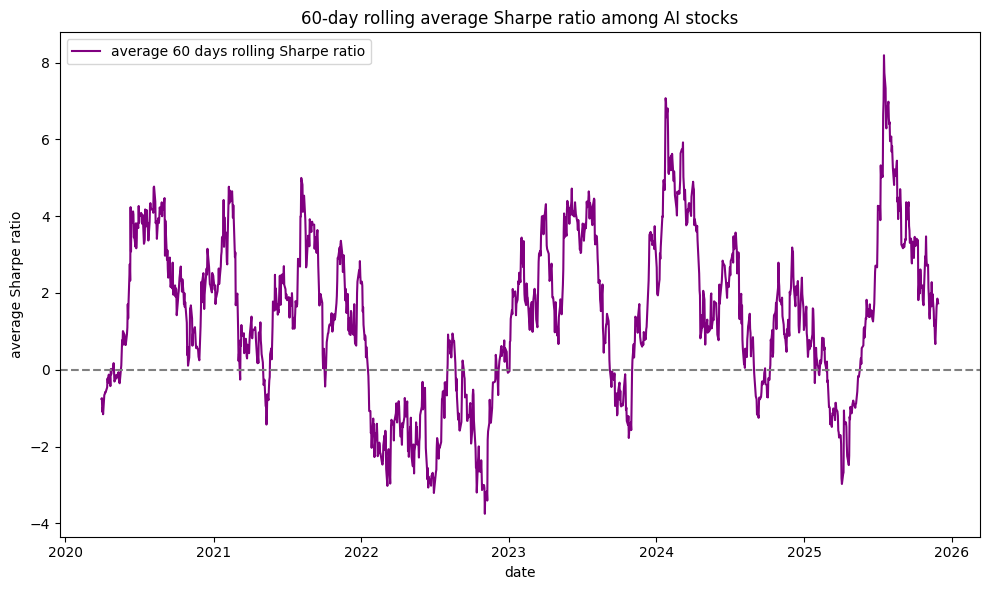

In [ ]:
# plot rolling Sharpe ratio for the AI index
plot_rolling_sharpe(rolling_sharpe)

In [87]:
# calculate drawdown for AI equal-weighted index
drawdown_ai = calculate_drawdown(ai_index)
drawdown_ai.tail(3)

Date
2025-11-25   -0.092298
2025-11-26   -0.076719
2025-11-28   -0.076378
Name: drawdown, dtype: float64

In [88]:
# calculate drawdown for QQQ benchmark
drawdown_qqq = calculate_drawdown(bench_indices["QQQ"])
drawdown_qqq.tail(3)

Date
2025-11-25   -0.042279
2025-11-26   -0.033817
2025-11-28   -0.025984
Name: drawdown, dtype: float64

In [89]:
# calculate drawdown for SPY benchmark
drawdown_spy = calculate_drawdown(bench_indices["SPY"])
drawdown_spy.tail(3)

Date
2025-11-25   -0.017996
2025-11-26   -0.011216
2025-11-28   -0.005819
Name: drawdown, dtype: float64

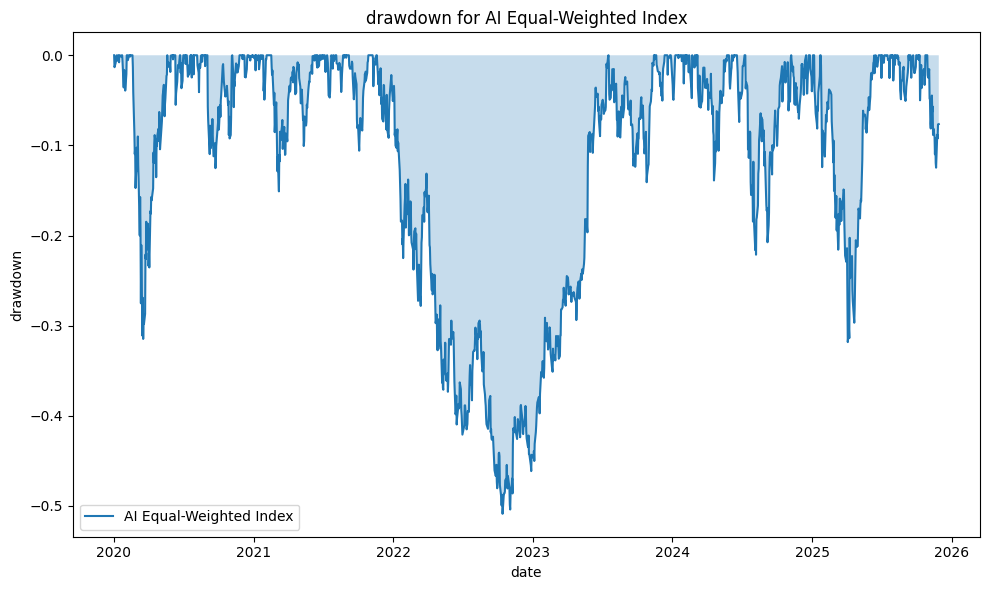

In [90]:
# plot drawdown for AI equal-weighted index
plot_drawdown(drawdown_ai, label="AI Equal-Weighted Index")

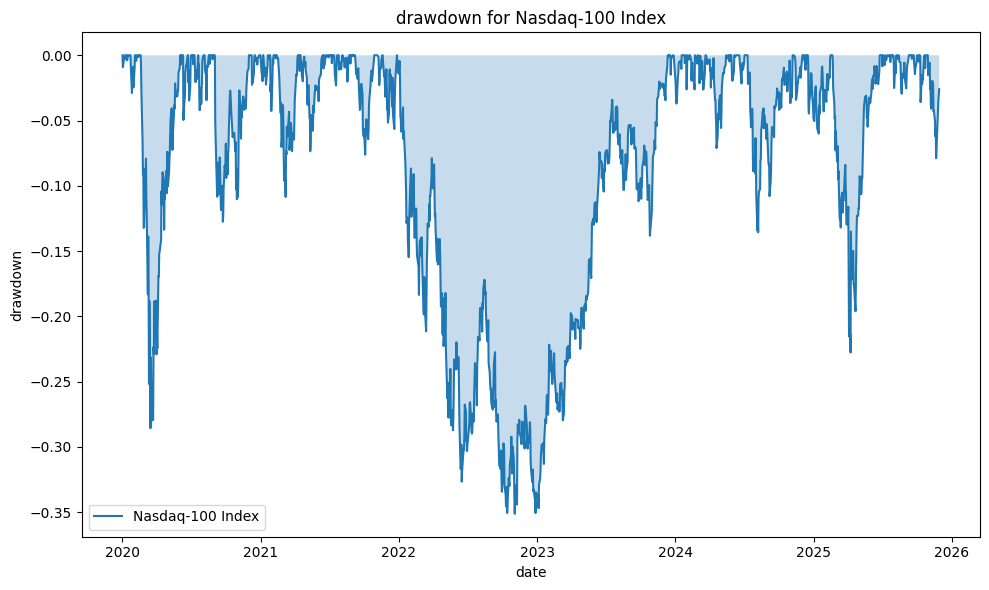

In [91]:
# plot drawdown for QQQ benchmark
plot_drawdown(drawdown_qqq, label="Nasdaq-100 Index")

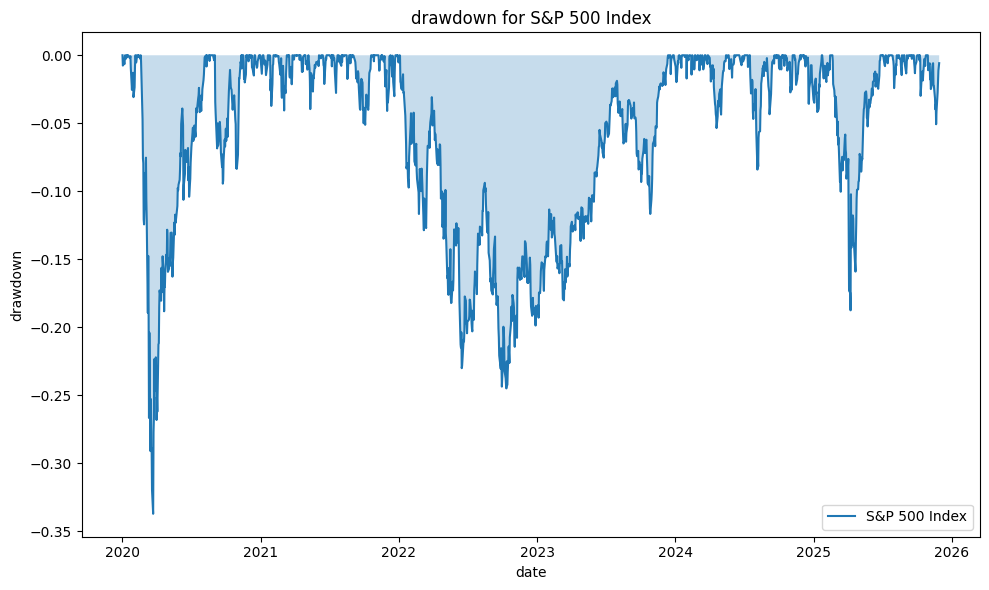

In [92]:
# plot drawdown for SPY benchmark
plot_drawdown(drawdown_spy, label="S&P 500 Index")

In [93]:
# calculate and store maximum drawdown values
mdd_values = {"AI Index": calculate_max_drawdown(ai_index)}

for ticker in ["QQQ", "SPY", "SOXX"]:
    mdd_values[ticker] = calculate_max_drawdown(bench_indices[ticker])

In [94]:
# print maximum drawdown values
print("Maximum Drawdowns:")
for name, value in mdd_values.items():
    print(f"  {name:<10}: {value:>7.2%}")

Maximum Drawdowns:
  AI Index  : -50.87%
  QQQ       : -35.12%
  SPY       : -33.72%
  SOXX      : -45.75%


a few patterns stand out:

- the AI basket tends to have **higher volatility** than QQQ/SPY, especially around inflection points.
- the rolling Sharpe ratio shows periods of **exceptionally high risk-adjusted returns**, particularly in the post-2023 AI rally.
- drawdown plots reveal that AI investors have endured **deeper and faster crashes** than holders of the broad market:
  - the worst peak-to-trough loss in the AI basket is larger than in QQQ, SPY, and SOXX.

this combination – **higher volatility, deeper drawdowns, but also bursts of very high Sharpe** – is typical of speculative themes: when things go well, they go *very* well, but the ride is rough.

## 6. return distributions: how “wild” are AI returns?

to dig into the shape of daily returns, i compare the **return distributions** of:

- the equal-weight AI basket,
- QQQ (Nasdaq-100),
- SPY (S&P 500),
- SOXX (Semiconductors ETF).

i use kernel density plots to see whether AI returns are more skewed or fat-tailed than the benchmarks.

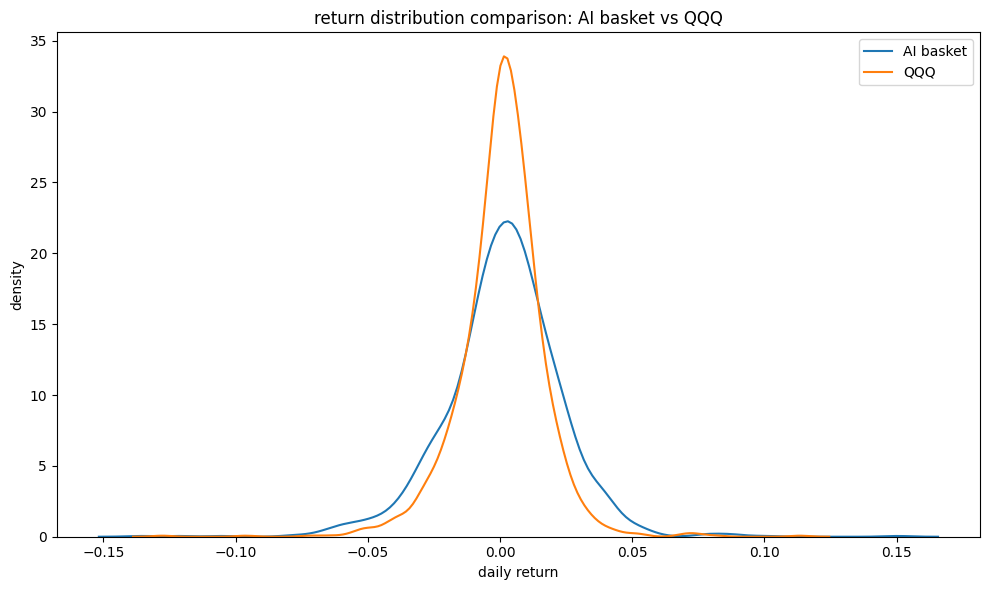

In [95]:
# plot return distribution for AI index vs. QQQ benchmark
plot_return_distribution(
    ai_index_returns, 
    bench_returns["QQQ"], 
    ai_label="AI basket", 
    benchmark_label="QQQ"
)

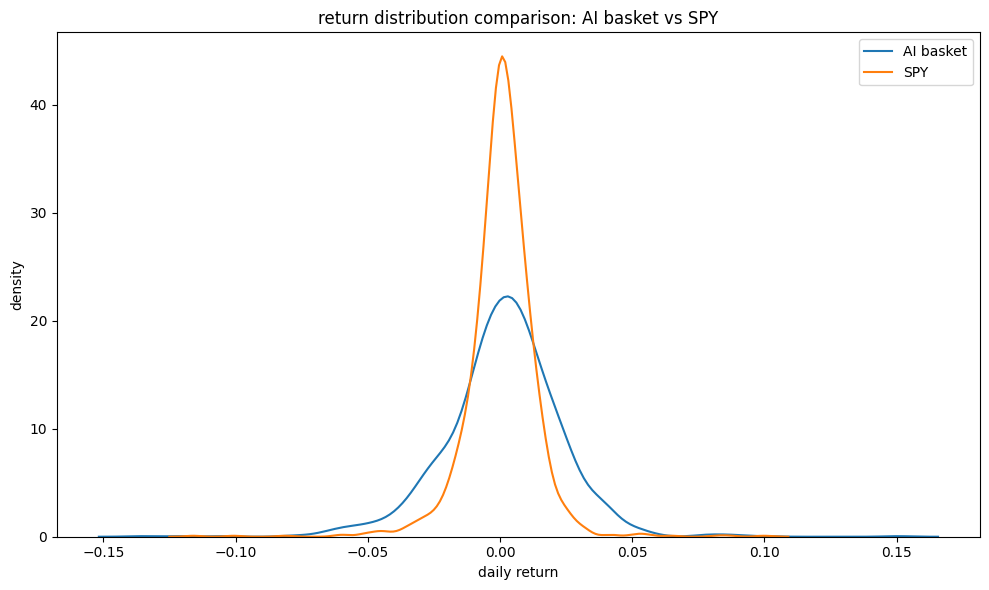

In [96]:
# plot return distribution for AI index vs. SPY benchmark
plot_return_distribution(
    ai_index_returns, 
    bench_returns["SPY"], 
    ai_label="AI basket", 
    benchmark_label="SPY"
)

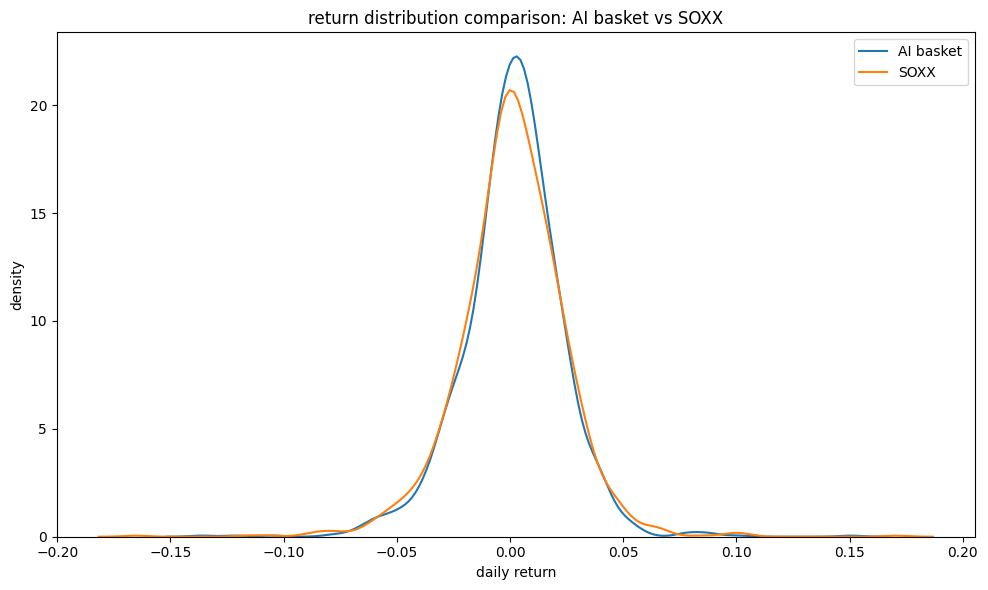

In [97]:
# plot return distribution for AI index vs. SOXX benchmark
plot_return_distribution(
    ai_index_returns, 
    bench_returns["SOXX"], 
    ai_label="AI basket", 
    benchmark_label="SOXX"
)

relative to QQQ and SPY, the AI basket shows:

- a wider distribution (more mass in both tails), consistent with **higher volatility**.
- more extreme positive and negative outliers, suggesting **fatter tails**.

relative to SOXX, the AI basket shows:

- a broadly **similar** distribution, which makes sense because both are heavily exposed to semiconductors

In practical terms, this means AI investors face **more frequent large moves** in both directions versus broad benchmarks, while behaving more like a “super-charged” version of the semiconductor sector.

## 7. conclusion: bubble, hype, or justified optimism?

this project cannot *prove* or *disprove* the existence of an “AI bubble” in a strict sense – that would require knowing future cash flows and discount rates. however, the evidence from market data points to a clear picture:

- the equal-weight **AI basket has massively outperformed** broad benchmarks (QQQ, SPY, SOXX) since 2020.
- this outperformance comes with **higher volatility**, **deeper drawdowns**, and a **fatter-tailed return distribution** than the benchmarks.
- AI-related stocks often move together, with **elevated return correlations**, especially during periods of stress or hype, suggesting they are traded as a single thematic “AI trade”.

putting everything together:

> the data provide **strong evidence of AI hype and concentrated optimism** in a subset of AI-related stocks. price behaviour, risk characteristics and elevated correlations all look consistent with a **speculative phase** in AI assets.

at the same time, some of the gains may be justified by genuine structural change and earnings growth, so it would be too strong to declare a clear, universal bubble.

so the most honest statement is:

> we are likely seeing **a powerful hype cycle, with bubble-like behaviour in some flagship AI names**, rather than a uniform bubble across everything related to AI.